## Import

In [0]:
!pip install -q torch==1.0.0 torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

## Data Loading

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
valloader = torch.utils.data.DataLoader(valset, batch_size = 4, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Model Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, init_xavier, batch_norm):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.init_xavier = init_xavier
        self.batch_norm = batch_norm
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        
        if self.act == 'relu':
            self.act = nn.ReLU()
            
        self.batch = nn.BatchNorm1d(self.hid_dim)
        self.drop = nn.Dropout()

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
            if self.batch_norm == True: x = self.batch(x)     # Batch Normalization
        x = self.fc2(x)          # 마지막 layer는 activation function 먹이지 않기!
        if self.dropout == True: x = self.drop(x)     # Dropout
        if self.init_xavier == True: x = nn.init.xavier_uniform_(x)     # Xavier Initializtion
        
        return x

## Experiment

In [0]:
import torch.optim as optim

def experiment(args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.init_xavier, args.batch_norm)
    net.cuda()
    
    criterion = nn.CrossEntropyLoss()
    if args.l2 == True: optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm, weight_decay=0.0005)
    else: optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_val_acc = []
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        # ===== Train ==== #
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072)        #-1은 입력된 값들로 나누고 남은 몫을 알아서 채워주는 기능(이 경우에는 4)
            
            # send datas to GPU
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_loss += loss.item()
            
        train_loss = train_loss / len(trainloader)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)
        
        # ===== Validation ===== #
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                images = images.cuda()
                labels = labels.cuda()
                
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            list_val_loss.append(val_loss)
            val_acc = 100 * correct / total
            list_val_acc.append(val_acc)
    
        print('Epoch {}, Train Loss: {:.2f}, Val Loss: {:.2f}, Val Acc: {:.2f}'.format(epoch, train_loss, val_loss, val_acc))
        
    # ====== Evaluation ====== #
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        
    return list_epoch, list_train_loss, list_val_loss, list_val_acc, test_acc

## Task

1. Train Loss랑 Val Loss epoch 별로 값 받아서 list로 저장 후 그래프 그리기
  -> overfitting되는 부분 찾아내기
2.  L2 Regularization, Dropout, Xavier Initialization, Batch Normalization 등도 PyTorch Library에서 찾아서 사용여부 argsparse에서 변수로 테스트해보기
3. Val Accuracy 가장 높은 하이퍼파라미터 튜닝 Test Accuracy 측정하기

In [0]:
# ========== 그래프 그리기 =========== #
import matplotlib.pyplot as plt

def draw_result(list_epoch, list_train_loss, list_val_loss, list_val_acc, test_acc):

    fig = plt.figure(figsize=(15,5))

    # ====== Epoch vs. Train Loss & Val Loss ====== #
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(list_epoch, list_train_loss, label='train_loss')
    ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.grid()
    ax1.legend()
    ax1.set_title('epoch vs loss')

    # ====== Epoch vs. Val Acc ====== #
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(list_epoch, list_val_acc, marker='x', label='Accuracy metric')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Acc')
    ax2.grid()
    ax2.legend()
    ax2.set_title('epoch vs Accuracy')

    plt.show()
    
    print('Test Acc: {:.2f}'.format(test_acc))

Epoch 0, Train Loss: 2.26, Val Loss: 2.23, Val Acc: 17.67
Epoch 1, Train Loss: 2.20, Val Loss: 2.16, Val Acc: 20.81
Epoch 2, Train Loss: 2.16, Val Loss: 2.14, Val Acc: 22.10


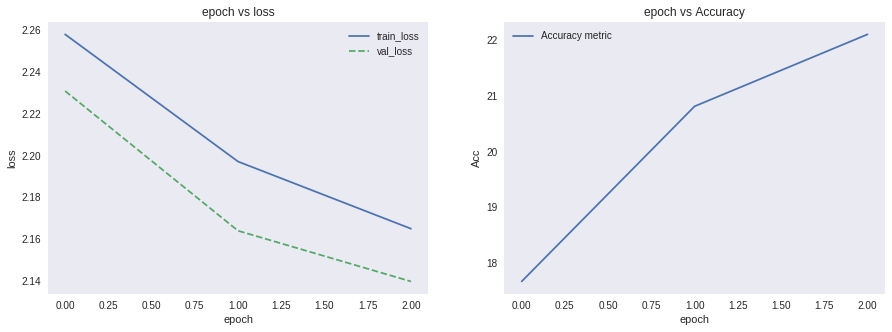

Test Acc: 21.98
Epoch 0, Train Loss: 2.11, Val Loss: 1.97, Val Acc: 28.59
Epoch 1, Train Loss: 1.95, Val Loss: 1.91, Val Acc: 31.75
Epoch 2, Train Loss: 1.89, Val Loss: 1.84, Val Acc: 32.94


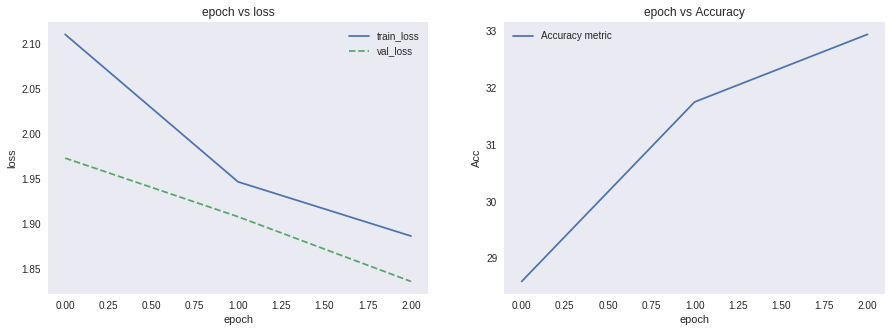

Test Acc: 31.85


In [12]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.n_layer = 5
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 3

# ========= Additional optimization ======== #
args.l2 = False
args.dropout = True
args.init_xavier = False
args.batch_norm = False

# ============ 변수 넣어보기 =========== #

list_change_lr = [0.001, 0.0001, 0.00001]
list_change_hid_dim = [50, 100, 150]
list_change_n_layer = [3, 5, 10]

list_change_l2 = [True, False]
list_change_dropout = [True, False]
list_change_init_xavier = [True, False]
list_change_batch_norm = [True, False]

for var1 in list_change_batch_norm:
        args.batch_norm = var1
        result = experiment(args)
        draw_result(result[0], result[1], result[2], result[3], result[4])
      